In [2]:
import h5py, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model
from sklearn.metrics import classification_report

2024-06-17 16:07:31.986034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 16:07:33.379832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
model_path = os.path.join(os.getcwd(), os.path.pardir, 'models')
model = load_model(os.path.join(model_path, 'model_enhanced_res_unet-v240618.keras'))
history = pd.read_csv(os.path.join(model_path, 'model_enhanced_res_unet-v240618.csv'))
history.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   classification_output_accuracy               14 non-null     float64
 1   classification_output_precision              14 non-null     float64
 2   classification_output_recall                 14 non-null     float64
 3   loss                                         14 non-null     float64
 4   segmentation_output_accuracy                 14 non-null     float64
 5   segmentation_output_mean_absolute_error      14 non-null     float64
 6   segmentation_output_mean_io_u                14 non-null     float64
 7   val_classification_output_accuracy           14 non-null     float64
 8   val_classification_output_precision          14 non-null     float64
 9   val_classification_output_recall             14 non-null     float64
 10  val_

In [12]:
train_loss = history["loss"]
val_loss = history["val_loss"]

train_acc_class = history["classification_output_accuracy"]
val_acc_class = history["val_classification_output_accuracy"]

train_acc_seg = history["segmentation_output_accuracy"]
val_acc_seg = history["val_segmentation_output_accuracy"]

train_meanIOU = history["segmentation_output_mean_io_u"]
val_meanIOU = history["val_segmentation_output_mean_io_u"]

train_mae_seg = history["segmentation_output_mean_absolute_error"]
val_mae_seg = history["val_segmentation_output_mean_absolute_error"]

train_precision_class = history["classification_output_precision"]
val_precision_class = history["val_classification_output_precision"]

train_recall_class = history["classification_output_recall"]
val_recall_class = history["val_classification_output_recall"]

def calculate_f1_score(precision, recall, epsilon=1e-9):
    return 2* (precision * recall) / (precision + recall + epsilon)

train_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(train_precision_class, train_recall_class)]
val_F1_score = [calculate_f1_score(precision, recall) for precision, recall in zip(val_precision_class, val_recall_class)]


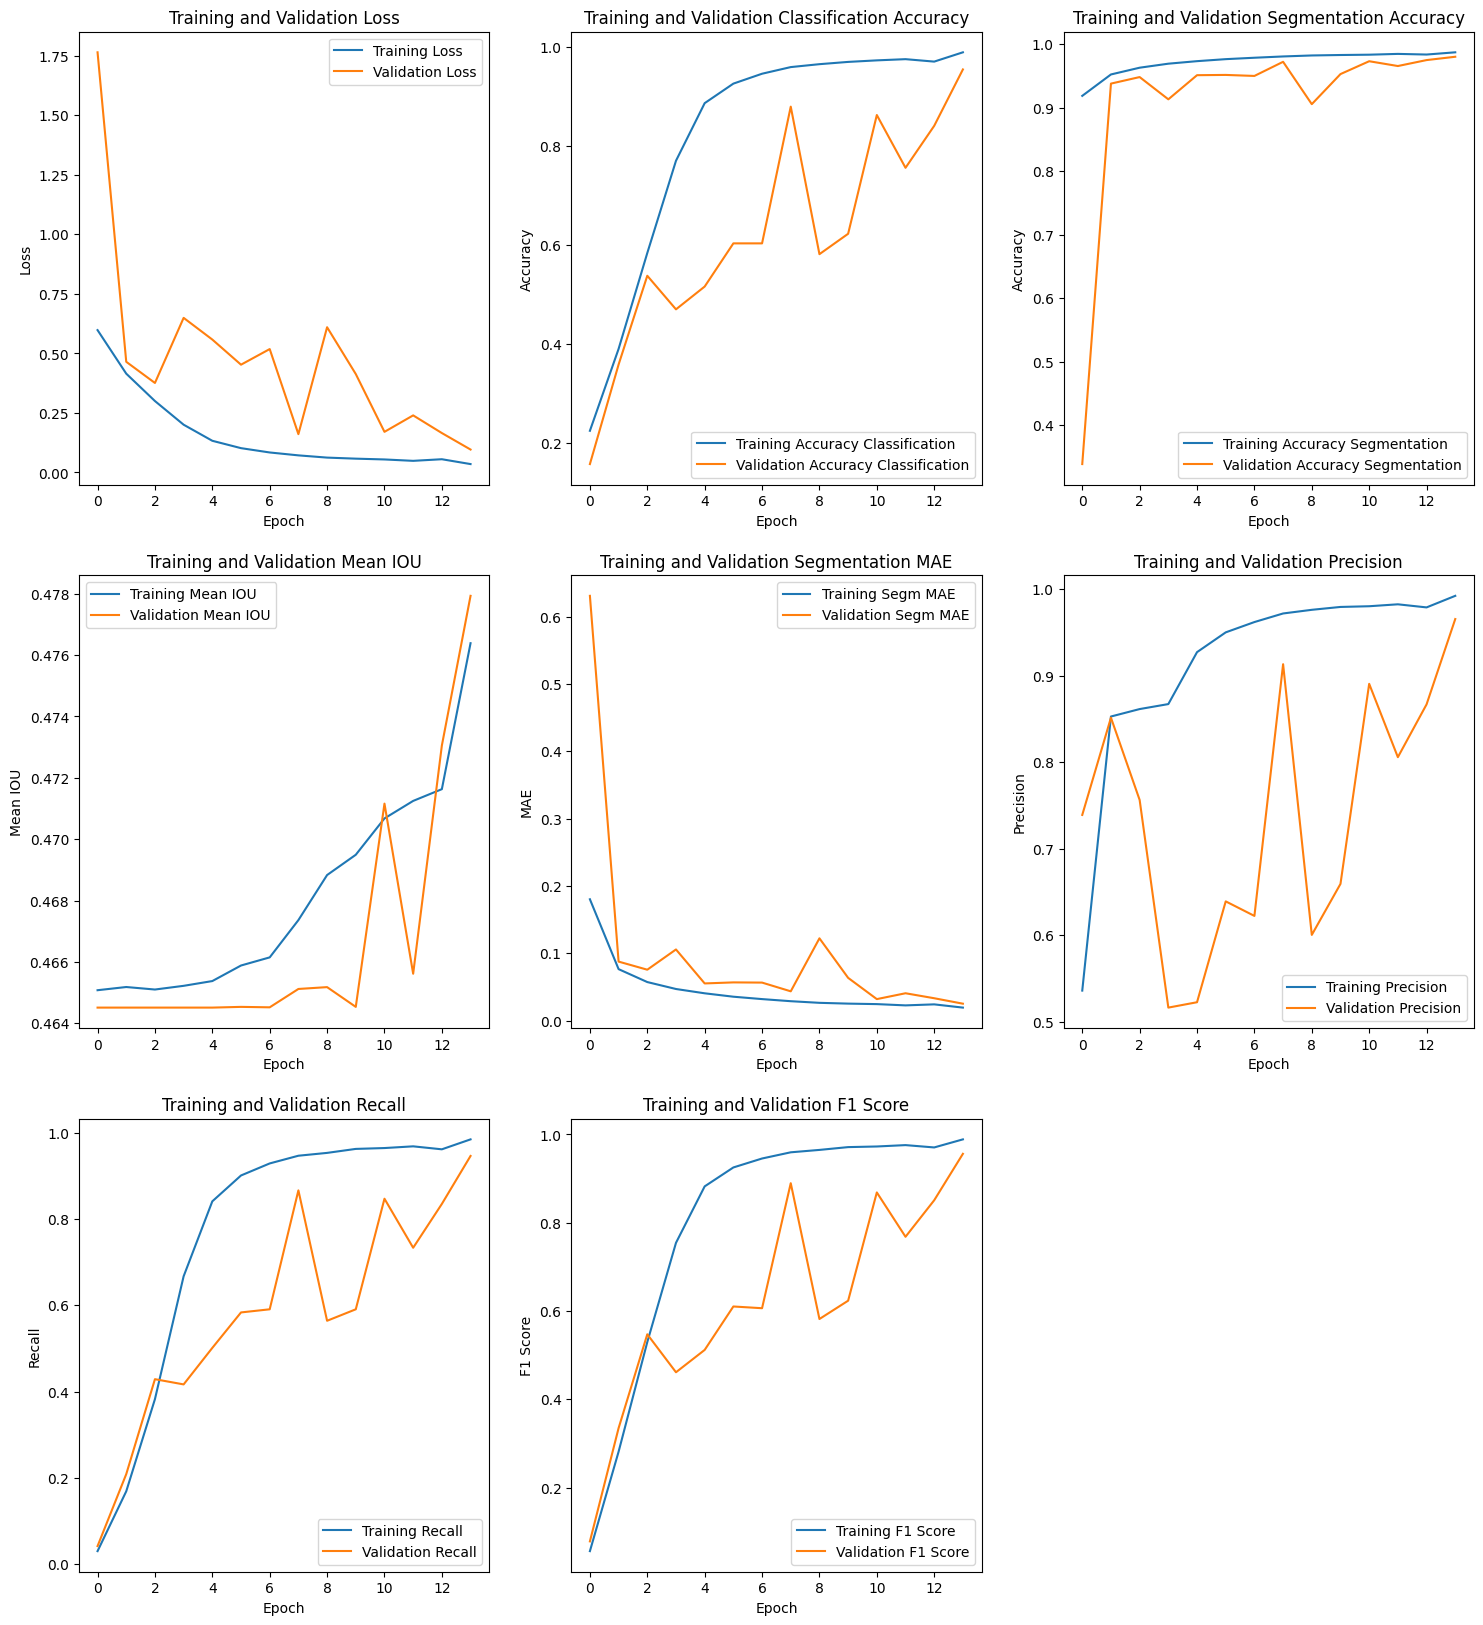

In [13]:

plt.figure(figsize = (18,20))

plt.subplot(3, 3, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(train_acc_class, label="Training Accuracy Classification")
plt.plot(val_acc_class, label="Validation Accuracy Classification")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Classification Accuracy")
plt.legend()

plt.subplot(3, 3, 3)
plt.plot(train_acc_seg, label="Training Accuracy Segmentation")
plt.plot(val_acc_seg, label="Validation Accuracy Segmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Segmentation Accuracy")
plt.legend()

plt.subplot(3, 3, 4)
plt.plot(train_meanIOU, label="Training Mean IOU")
plt.plot(val_meanIOU, label="Validation Mean IOU")
plt.xlabel("Epoch")
plt.ylabel("Mean IOU")
plt.title("Training and Validation Mean IOU")
plt.legend()

plt.subplot(3, 3, 5)
plt.plot(train_mae_seg, label="Training Segm MAE")
plt.plot(val_mae_seg, label="Validation Segm MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation Segmentation MAE")
plt.legend()

plt.subplot(3, 3, 6)
plt.plot(train_precision_class, label="Training Precision")
plt.plot(val_precision_class, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(3, 3, 7)
plt.plot(train_recall_class, label="Training Recall")
plt.plot(val_recall_class, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(3, 3, 8)
plt.plot(train_F1_score, label="Training F1 Score")
plt.plot(val_F1_score, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score")
plt.legend()

#plt.tight_layout()
plt.show()

In [16]:
downloads_path = os.path.join(os.path.expanduser('~'),"Downloads")

# Step 1: Open the HDF5 file
file_name = 'test_data.h5'
file_path = os.path.join(downloads_path, file_name)
with h5py.File(file_path, 'r') as hdf:
    # Step 2: List all groups
    print(f"Keys: {hdf.keys()}")
    # Get the name of the dataset you want to read
    dataset_names = list(hdf.keys())

    # Step 3: Extract the dataset
    X_test = np.asarray(hdf[dataset_names[0]])
    y_test_class_cat = np.asarray(hdf[dataset_names[1]])
    y_test_mask = np.asarray(hdf[dataset_names[2]])

    #print(type(X_test))

    # Step 4: Read the data into a NumPy array
    #X_test = dataset[:]

# Step 5: Use the data
X_test = np.expand_dims(X_test, axis=3)

print(X_test.shape)
print(y_test_mask.shape)
print(y_test_class_cat.shape)


Keys: <KeysViewHDF5 ['X', 'y_class_cat', 'y_mask']>
(413, 100, 100, 1)
(413, 100, 100)
(413, 7)


In [17]:
y_pred_mask, y_pred_class_cat = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


In [18]:
labels = ['missing hole', 'mouse_bite', 'none', 'open circuit', 'short', 'spur', 'spurious copper']
y_test_class = list(map(lambda cat: labels[np.argmax(cat)], y_test_class_cat))
y_pred_class = list(map(lambda cat: labels[np.argmax(cat)], y_pred_class_cat))


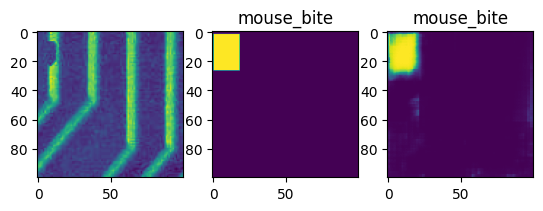

In [27]:
rnd = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_test[rnd])
ax[1].imshow(y_test_mask[rnd])
ax[1].set_title(y_test_class[rnd])
ax[2].imshow(y_pred_mask[rnd])
ax[2].set_title(y_pred_class[rnd]);

In [19]:
crosstab = pd.crosstab(y_test_class, y_pred_class)

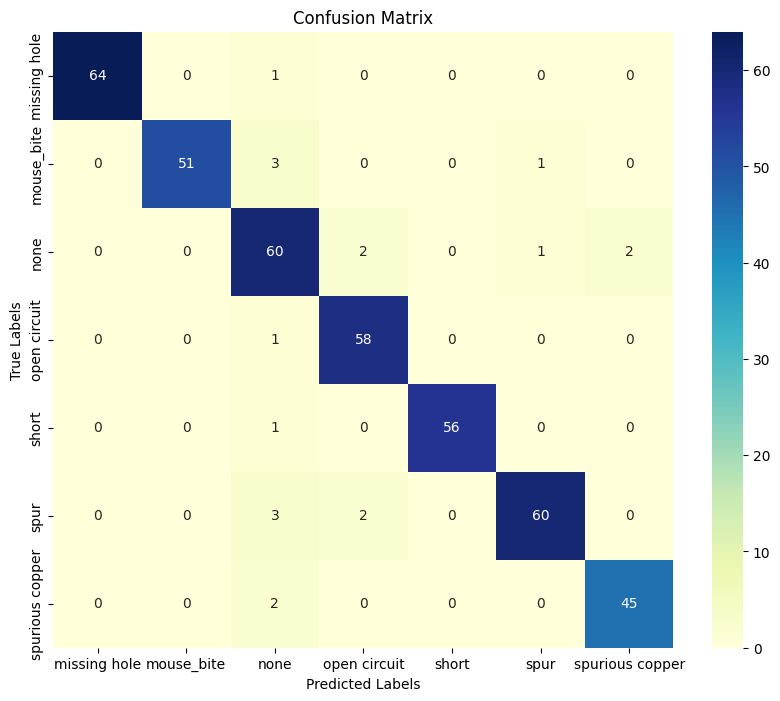

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
print(classification_report(y_test_class, y_pred_class))

                 precision    recall  f1-score   support

   missing hole       1.00      0.98      0.99        65
     mouse_bite       1.00      0.93      0.96        55
           none       0.85      0.92      0.88        65
   open circuit       0.94      0.98      0.96        59
          short       1.00      0.98      0.99        57
           spur       0.97      0.92      0.94        65
spurious copper       0.96      0.96      0.96        47

       accuracy                           0.95       413
      macro avg       0.96      0.95      0.96       413
   weighted avg       0.96      0.95      0.95       413

